In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,GridSearchCV
%matplotlib inline

In [2]:
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
                      header=None,
                      names=["buying price", "maintenance cost", "number of doors",
                             "number of persons", "lug_boot", "safety", "decision"])
dataset.head()

,buying price,maintenance cost,number of doors,number of persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


#  About Data:

- The data contains 1728 rows and 7 columns with descriptions as follows:
    - buying price: Buying Level or Capacity of the customer (Very High:vhigh, High:high, Low:low, Medium:med)
    - maintenance cost: Maintainence Level (Very High:vhigh, High:high, Low:low, Medium:med)
    - number of doors: Number of doors in the car (2, 3, 4 and 5 or more)
    - number of persons: Max number of persons can sit at a time(2,4 and more)
    - lug_boot: Luggage Boot Size in the car (small, med, big)
    - safety: Safety Level of Car (high, med, low)
    - class: Unacceptable, Acceptable, VeryGood, Good
- The data is a classic multi-class classification task with multiple classes of cars available as the final evaluation
- The data does not have any missing values
- The data does not have repetitive columns
- The data is fully categorical with even the final target variable is also in form of a category

#  Data Analysis:

<AxesSubplot:xlabel='decision', ylabel='count'>

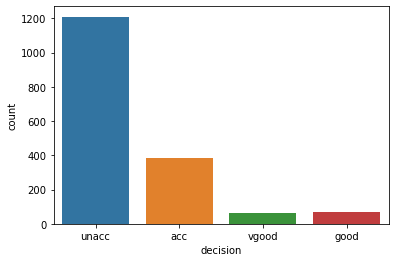

In [3]:
sns.countplot(x=dataset['decision'])

From the above graph it can be seen that target column is unbalanced with larger values of 'unacceptable'.Hence it is a unbalanced multiclass problem.

Below graphs are showing how classes are distributed in each of the feature of our data.

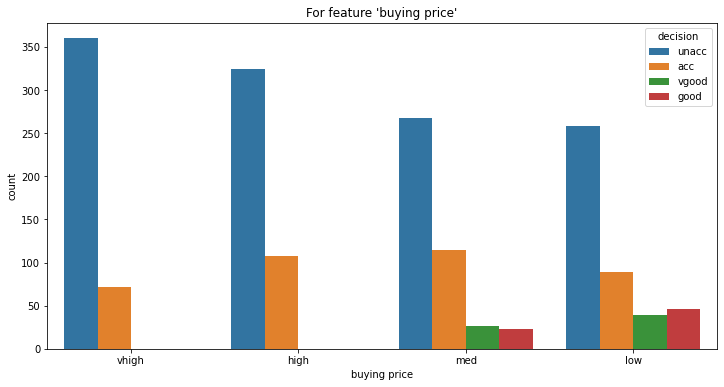

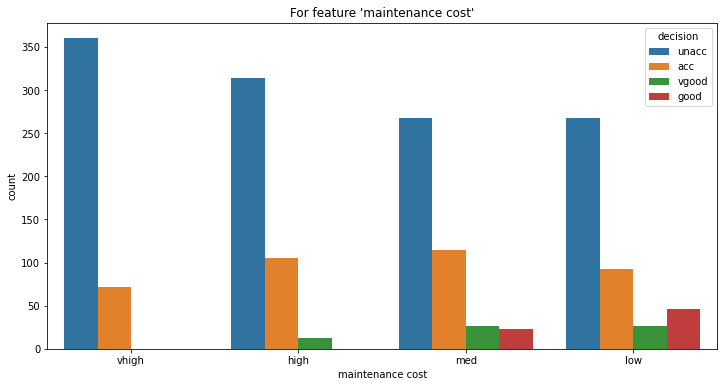

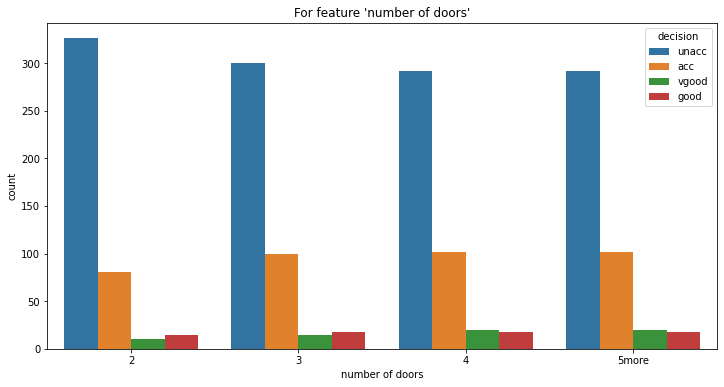

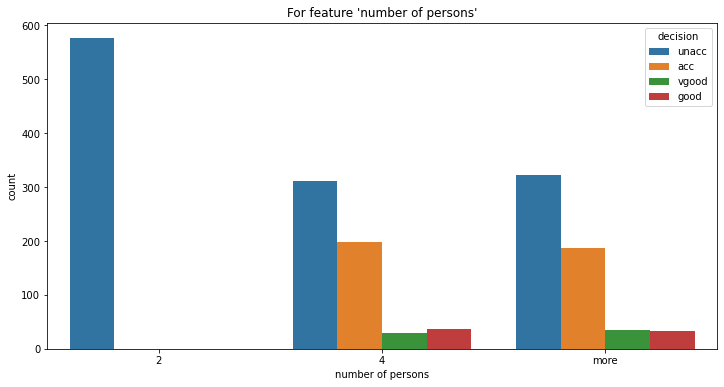

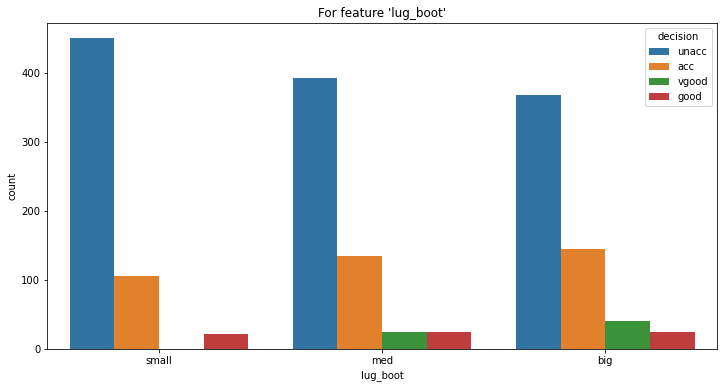

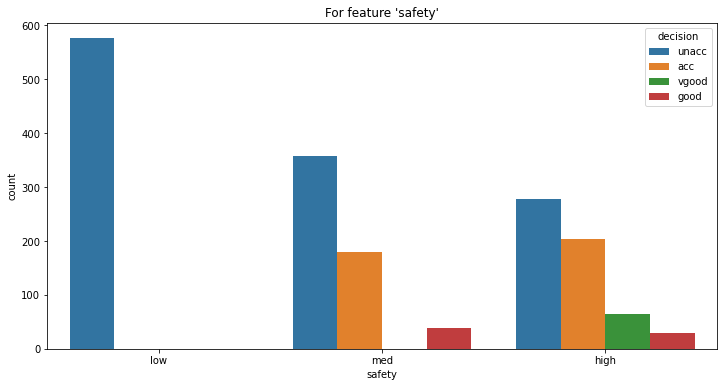

In [4]:
for i in dataset.columns[:-1]:
    plt.figure(figsize=(12,6))
    plt.title("For feature '%s'"%i)
    sns.countplot(x=dataset[i],hue=dataset['decision'])

#  Preprocessing:

In [5]:
X = dataset.drop("decision", axis=1)
y = dataset.decision

#### I have used one hot encoding to convert categorical values into numeric.

In [6]:
X = pd.get_dummies(X)
X.head()

,buying price_high,buying price_low,buying price_med,buying price_vhigh,maintenance cost_high,maintenance cost_low,maintenance cost_med,maintenance cost_vhigh,number of doors_2,number of doors_3,...,number of doors_5more,number of persons_2,number of persons_4,number of persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [7]:
y = y.replace(
    {
        "unacc" : 0,
        "acc" : 1,
        "good" : 2,
        "vgood" : 3
    }
)
y.value_counts()

0    1210
1     384
2      69
3      65
Name: decision, dtype: int64

#### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Model Building:

# 1) Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

### Training with default hyperparameter

In [10]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)
print(dtc.score(X_test,y_test))

0.976878612716763


In [11]:
print("K-fold Cross validation score is: ",cross_val_score(estimator = dtc, X = X, y = y, cv = 10).mean())

K-fold Cross validation score is:  0.8455269525473854


### Hyperparamter tunning

#### Since the dataset is small i have used gridsearch for parameter tunning.It searches over all the given parameters and gives best out of it.

In [12]:
para_grid_dtc={"criterion":['gini','entropy'],
           "max_depth":range(1,20),
           "min_samples_split":range(1,10),
           "min_samples_leaf":range(1,5)}

In [13]:
grid=GridSearchCV(estimator=dtc,param_grid=para_grid_dtc,cv=10,n_jobs=-1)
grid.fit(X_train,y_train)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.68741529 0.68741529 ... 0.95877906 0.95805443 0.95877906]
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)})

In [14]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9761286622875615


### Final Model:

In [15]:
dtc_final=DecisionTreeClassifier(criterion= str(grid.best_params_['criterion']), max_depth=grid.best_params_['max_depth'],
                                 min_samples_leaf= grid.best_params_['min_samples_leaf'],
                                 min_samples_split= grid.best_params_['min_samples_split'])

# 2) Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

### Training with default hyperparameter

In [17]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
print(rfc.score(X_test,y_test))

0.9479768786127167


In [18]:
print('K-fold crossvalidation score is: ',cross_val_score(estimator = rfc, X = X, y = y, cv = 10).mean())

K-fold crossvalidation score is:  0.8443944078505176


### Hyperparameter Tunning

In [19]:
param_grid={'criterion':['gini','entropy'],
           'max_depth':[2,5,10,20],
           'max_features':[2,4,6,'auto'],
           'max_leaf_nodes':[2,3,None],}

In [20]:
grid=GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=51),
                  param_grid=param_grid,cv=10,n_jobs=-1)

In [21]:
grid.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              random_state=51),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 20],
                         'max_features': [2, 4, 6, 'auto'],
                         'max_leaf_nodes': [2, 3, None]})

In [22]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 20, 'max_features': 6, 'max_leaf_nodes': None}
0.969596496715671


### Final Model:

In [23]:
rfc_final=RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=51,criterion= str(grid.best_params_['criterion']),
                                 max_depth=grid.best_params_['max_depth'] , max_features= grid.best_params_['max_features'],
                                 max_leaf_nodes= grid.best_params_['max_leaf_nodes'])

# 3) KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

### Training with default parameter

In [25]:
knn=KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train,y_train)
print(knn.score(X_test,y_test))

0.8988439306358381


In [26]:
print('K-fold cross validation score is: ',cross_val_score(estimator = knn, X = X, y = y, cv = 10).mean())

K-fold cross validation score is:  0.7379788950127705


### Hyperparameter Tunning

In [27]:
k_range = list(range(1, 31))
para_grid_knn = dict(n_neighbors=k_range)

In [28]:
grid=GridSearchCV(estimator=knn,param_grid=para_grid_knn,cv=10,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]})

In [29]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 11}
0.9073923469919716


### Final Model:

In [30]:
knn_final=KNeighborsClassifier(n_neighbors= grid.best_params_['n_neighbors'],n_jobs=-1)

# 4) Naive bayes

In [31]:
from sklearn.naive_bayes import GaussianNB

### Training with default parameter

In [32]:
nbc=GaussianNB()
nbc.fit(X_train,y_train)
print(nbc.score(X_test,y_test))

0.838150289017341


In [33]:
print("K-fold Cross validation score is: ",cross_val_score(estimator = nbc, X = X, y = y, cv = 10).mean())

K-fold Cross validation score is:  0.8027624680736658


### Hyperparameter tunning

In [34]:
para_grid_nbc = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [35]:
grid=GridSearchCV(estimator=nbc,param_grid=para_grid_nbc,cv=10,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [36]:
print(grid.best_params_)
print(grid.best_score_)

{'var_smoothing': 1.0}
0.8769575643832761


### Final model:

In [37]:
nbc_final=GaussianNB(var_smoothing= grid.best_params_['var_smoothing'] )

# Model Comparison

In [38]:
models=[rfc_final,dtc_final,knn_final,nbc_final]
row_num = 0
model_compare = pd.DataFrame()

In [39]:
for classifier in models:
    
    classifier.fit(X_train, y_train) 
    classifier_accuracy_score = classifier.score(X_test,y_test)
    kfold_accuracy = cross_val_score(estimator = classifier, X = X, y = y, cv = 10)
    model_name = classifier.__class__.__name__
    model_compare.loc[row_num, 'Classifier Name'] = model_name
    model_compare.loc[row_num, 'Accuracy Score'] = classifier_accuracy_score*100
    model_compare.loc[row_num, 'K-Fold Accuracy'] = kfold_accuracy.mean()*100
    row_num+=1

In [40]:
model_compare = model_compare.sort_values(by="K-Fold Accuracy", ascending=False).reset_index(drop=True) 
model_compare

,Classifier Name,Accuracy Score,K-Fold Accuracy
0,RandomForestClassifier,95.375723,85.478895
1,DecisionTreeClassifier,95.953757,84.206883
2,GaussianNB,90.462428,76.222947
3,KNeighborsClassifier,91.907514,75.185173
